In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16

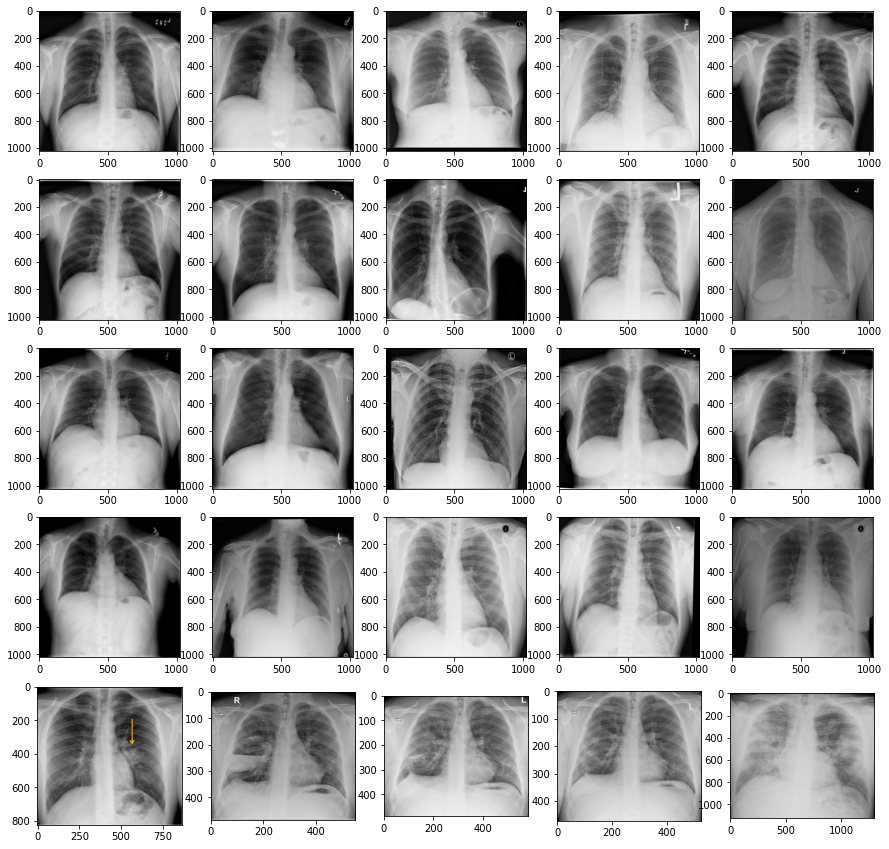

In [2]:
#Mostramos unas cuántas imagenes
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))
carpeta='C:\\Users\\hecto\\Downloads\\MachineCrypto\\Proyecto\\dataset\\Xray-sanos'
imagenes=os.listdir(carpeta)

for i, name in enumerate(imagenes[:25]):
    plt.subplot(5,5,i+1)
    imagen=mpimg.imread(carpeta+'/'+name)
    plt.imshow(imagen)

In [45]:
from keras.applications.densenet import DenseNet121
conv_base=DenseNet121(input_shape=(224,224,3),weights="imagenet",include_top=True)

In [4]:
train_dir='C:\\Users\\hecto\\Downloads\\MachineCrypto\\Proyecto\\dataset'
#Corregir este punto, puse los mismos de validación sólo para ver si se ejecutava el código

valid_dir='C:\\Users\\hecto\\Downloads\\MachineCrypto\\Proyecto\\dataset'
img_width, img_height = 224, 224

In [47]:
# Paso de extracción de características con modelo DenseNet121
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 1000))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count,2))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='categorical')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, 269)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(valid_dir, 269)
# test_features, test_labels = extract_features(test_dir, test_size)

Found 269 images belonging to 2 classes.
1/1 [==============================] - 2s 2s/step


ValueError: could not broadcast input array from shape (32,7,7,1024) into shape (32,1000)

In [6]:
#Dimensiones del vector de características
print(train_labels.shape)
print(train_features.shape)

(269, 2)
(269, 1000)


In [31]:
#Aquí ya no importa que haya puesto los datos de validacioón y entrenamiento iguales, aquí sólo tomo un conjunto y divido para la validación
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, stratify=train_labels, random_state=10)

In [32]:
y_test.shape

(68, 2)

In [33]:
y_testeo=np.zeros(68)
for i in range(68):
    if y_test[i][0]==1:
        y_testeo[i]=1
    elif y_test[i][1]==1:
        y_testeo[i]=2

print(i)

67


In [34]:
print(X_train.shape)
print(X_test.shape)

(201, 1000)
(68, 1000)


In [35]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

In [36]:
scores = cross_val_score(DecisionTreeClassifier(), train_features, train_labels, cv=5)
print(scores)

[0.92592593 0.90740741 0.85185185 0.87037037 0.94339623]


In [37]:
scores.mean()

0.89979035639413

In [38]:
#Creamos ya el modelo con Bagging
bag_model = BaggingClassifier(
base_estimator=DecisionTreeClassifier(), 
n_estimators=5
)

In [39]:
#El modelo de Bagging sólo acepta entradas de etiquetas de una dimensión, así que aquí creo el vector etiquetas pero para que tenga solo  una dimensión (1000)
y=np.zeros(201)
for i in range(y_train.shape[0]):
    if y_train[i][0]==1:
        y[i]=1
    elif y_train[i][1]==1:
        y[i]=2
print(i)

200


In [51]:
scores = cross_val_score(BaggingClassifier(
base_estimator=DecisionTreeClassifier(), 
n_estimators=5
), X_train, y, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
scores.mean()

0.93 accuracy with a standard deviation of 0.04


0.9254761904761905

In [41]:
scores = cross_validate(BaggingClassifier(
base_estimator=DecisionTreeClassifier(), 
n_estimators=5
), X_train, y, cv=10)
sorted(scores.keys())


['fit_time', 'score_time', 'test_score']

In [42]:
scores['test_score'].mean()

0.8959523809523808

In [17]:
pred=cross_val_predict(BaggingClassifier(
base_estimator=DecisionTreeClassifier(), 
n_estimators=5
), X_train, y, cv=10)

In [18]:
#Clasificamos
bag_model.fit(X_train, y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=5)

In [19]:
y_test[0]

array([0., 1.])

67


In [21]:
y_testeo

array([2., 1., 1., 1., 1., 2., 2., 2., 1., 1., 1., 2., 1., 1., 1., 1., 2.,
       2., 1., 2., 1., 2., 2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 2., 2.,
       2., 2., 2., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1.,
       1., 2., 1., 2., 1., 2., 1., 2., 2., 2., 2., 2., 1., 2., 2., 2., 1.])

In [22]:
bag_model.score(X_test, y_testeo)

0.8529411764705882